In [1]:
#JUST SETTING UP JUPYTER NOTEBOOK PREFERENCES
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                   exception_only=False, running_compiled_code=False):
    etype, value, tb = sys.exc_info()
    value.__cause__ = None  # suppress chained exceptions
    return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [2]:
from blocks import residual_block, residual_block_id, ConvBlock, MaxPoolBlock
from augment import preprocess_fn

import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import cv2
import keras
from PIL import Image
import keras.backend as K
import tensorflow as tf

In [3]:
#directly into memory, load image paths, plus 84 (x,y) keypoints == 168 annotations
#actual images lazy loaded  with Tensorflow Dataset
key_pts_frame = pd.read_csv('/data/training_frames_keypoints.csv')
#reorder so image paths match os.walk order
key_pts_frame = key_pts_frame.sort_values(by='Unnamed: 0')
key_pts = key_pts_frame.iloc[:, 1:].values
key_pts = key_pts.reshape(-1,68,2)
key_pts_frame.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
2126,Abdel_Aziz_Al-Hakim_00.jpg,65.0,109.0,69.0,131.0,73.0,149.0,82.0,162.0,96.0,...,180.0,155.0,193.0,155.0,180.0,164.0,171.0,164.0,162.0,163.0
2006,Abdel_Aziz_Al-Hakim_01.jpg,74.0,103.0,78.0,125.0,83.0,143.0,91.0,157.0,100.0,...,184.0,149.0,197.0,149.0,184.0,154.0,175.0,158.0,166.0,158.0
1416,Abdel_Aziz_Al-Hakim_02.jpg,79.0,94.0,83.0,112.0,88.0,134.0,97.0,148.0,106.0,...,185.0,140.0,198.0,141.0,190.0,149.0,181.0,149.0,172.0,149.0
3324,Abdel_Aziz_Al-Hakim_10.jpg,65.0,111.0,68.0,123.0,71.0,132.0,74.0,142.0,80.0,...,105.0,139.0,120.0,136.0,105.0,139.0,102.0,142.0,95.0,142.0
2703,Abdel_Aziz_Al-Hakim_11.jpg,89.0,95.0,86.0,107.0,86.0,116.0,86.0,128.0,86.0,...,119.0,129.0,128.0,132.0,116.0,132.0,113.0,132.0,110.0,129.0


In [4]:
n_instances = key_pts_frame.shape[0]
#get list of image paths
img_paths = key_pts_frame.iloc[:,0].values
#collect original image size data to stretch label coords at same ratio as stretching images
orig_sizes = np.empty(n_instances,dtype=object)

for i, path in enumerate(img_paths):
    img = Image.open(os.path.join('/data/training_super/training',path))#wont actually bring images into memory
    orig_sizes[i] = img.size

In [5]:
#stretch each label coord to match the stretch of its corresponding image
STD_W = 100
STD_H = 100
STD_SIZE = (STD_W,STD_H)

for i in range(n_instances):
    resize_ratio_W = STD_W/orig_sizes[i][0]
    resize_ratio_H = STD_H/orig_sizes[i][1]
    key_pts[i][:,0] = key_pts[i][:,0]*resize_ratio_W
    key_pts[i][:,1] = key_pts[i][:,1]*resize_ratio_H



In [6]:
key_pts.shape

(3462, 68, 2)

In [7]:
key_pts

array([[[20.83333333, 40.37037037],
        [22.11538462, 48.51851852],
        [23.3974359 , 55.18518519],
        ...,
        [57.69230769, 60.74074074],
        [54.80769231, 60.74074074],
        [51.92307692, 60.37037037]],

       [[23.71794872, 38.14814815],
        [25.        , 46.2962963 ],
        [26.6025641 , 52.96296296],
        ...,
        [58.97435897, 57.03703704],
        [56.08974359, 58.51851852],
        [53.20512821, 58.51851852]],

       [[25.32051282, 34.81481481],
        [26.6025641 , 41.48148148],
        [28.20512821, 49.62962963],
        ...,
        [60.8974359 , 55.18518519],
        [58.01282051, 55.18518519],
        [55.12820513, 55.18518519]],

       ...,

       [[21.47435897, 45.92391304],
        [24.35897436, 51.90217391],
        [27.24358974, 55.43478261],
        ...,
        [59.61538462, 61.95652174],
        [56.73076923, 61.95652174],
        [53.84615385, 63.04347826]],

       [[24.35897436, 47.01086957],
        [25.64102564, 51.90

In [8]:
def heatmap_from_key_pts(key_pts_list, sizew=100,sizeh=100):
    heatmap = np.zeros(shape=(sizeh,sizew))
    for x, y in key_pts_list:
        x = int(np.round(x,0))-1
        y = int(np.round(y,0))-1
        if x >= sizew: x = sizew -1
        if y >= sizeh: y = sizeh -1
        heatmap[x][y] = 1
    return heatmap
# heatmap_key_pts = []     
# i= 0
# while i<key_pts.shape[0]:
#     heatmap_key_pts.append(heatmap_from_key_pts(key_pts[i]))
#     i=i+1


In [9]:
# train_label_dataset = tf.data.Dataset.from_tensor_slices(key_pts[:,np.array([40,43,31,9])-1])#four keypoints representative keypoints
train_label_dataset = tf.data.Dataset.from_tensor_slices(key_pts)
train_label_dataset

<TensorSliceDataset shapes: (68, 2), types: tf.float64>

In [10]:
#build image dataset

#stretching all images to intermediate size 
BATCH_SIZE = 2 #************************************LOWER FOR TESTING************************
#note that keras requires a super-directory workaround or renaming files if filenames have a certain format
#note drop remainder not available in this method
train_image_dataset = keras.preprocessing.image_dataset_from_directory(
    '/data/training_super/', label_mode=None,
    class_names=None, color_mode='rgb', batch_size=1, image_size=STD_SIZE, shuffle=False, interpolation='bicubic'
) 
train_image_dataset = train_image_dataset.unbatch()
#combine training image and label datasets
train = tf.data.Dataset.zip((train_image_dataset,train_label_dataset))

Found 3462 files belonging to 1 classes.


In [11]:
#  use the python code in graph mode
train = train.map(lambda x,y: tf.py_function(func=preprocess_fn,
      inp=[x,y], Tout=[tf.float32,tf.float32]))

In [12]:
train = train.map(lambda x,y: (x     , tf.py_function(func=heatmap_from_key_pts,inp=[y], Tout=[tf.float32])))
train = train.map(lambda x, y: (x, tf.reshape(y, shape=[100,100])))
# [x for x in train]

In [13]:
train = train.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

#20% for validation
#TODO: write helper fxns for this
valid = train.enumerate().filter(lambda x, y: x%5==0)
valid= valid.map(lambda x,y:y)

train = train.enumerate().filter(lambda x, y: x%5!=0)
train= train.map(lambda x,y:y)

In [14]:
DEPTH_POOL_SIZE = 2

I = keras.layers.Input(shape=[100, 100,3])

Z = ConvBlock(kernel_size=5, strides=2,filters=64, rate = 0)(I)
Z = ConvBlock(kernel_size=3, strides=1,filters=64, rate = 0)(Z)
Z = MaxPoolBlock(pool_size=3, strides=2, rate = 0)(Z)
Z = ConvBlock(kernel_size=3, strides=1,filters=64, rate = 0)(Z)
Z = ConvBlock(kernel_size=3, strides=1,filters=64, rate = 0)(Z)
Z = MaxPoolBlock(pool_size=3, strides=2, rate = 0)(Z)
Z = ConvBlock(kernel_size=3, strides=2,filters=128, rate = 0)(Z)
Z = ConvBlock(kernel_size=3, strides=2,filters=128, rate = 0)(Z)
Z = ConvBlock(kernel_size=3, strides=2,filters=256, rate = 0)(Z) 
Z = ConvBlock(kernel_size=4, strides=4,filters=500, rate = 0)(Z) 
Z = keras.layers.GlobalMaxPool2D()(Z)
Z = keras.layers.Reshape((*Z.shape[1:],1))(Z)
Z = keras.layers.UpSampling1D(20, interpolation='bilinear')(Z)


Z = keras.layers.Activation('sigmoid')(Z)
Z = keras.layers.Reshape(target_shape=[100,100])(Z)

# Z = keras.layers.Lambda(lambda x: nms(s))#non maximum supression


model= tf.keras.Model(inputs=I, outputs=Z)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv_block (ConvBlock)       (None, 50, 50, 64)        5120      
_________________________________________________________________
conv_block_1 (ConvBlock)     (None, 50, 50, 64)        37184     
_________________________________________________________________
max_pool_block (MaxPoolBlock (None, 24, 24, 64)        256       
_________________________________________________________________
conv_block_2 (ConvBlock)     (None, 24, 24, 64)        37184     
_________________________________________________________________
conv_block_3 (ConvBlock)     (None, 24, 24, 64)        37184     
_________________________________________________________________
max_pool_block_1 (MaxPoolBlo (None, 11, 11, 64)        256   

In [15]:
train = train.repeat(int(1e10))

In [16]:
K.clear_session()
root_logdir = os.path.join(os.curdir, "keypoint_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
print('run logged at:' ,run_logdir)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
checkpoint_cb = keras.callbacks.ModelCheckpoint('keypoint_model', save_best_only=True)
early_stop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)



optimizer = keras.optimizers.Nadam(lr=0.1)

model.compile(loss='binary_crossentropy', optimizer=optimizer)

run logged at: ./keypoint_logs/run_2021_01_23-18_46_18


In [17]:
# xxx = [x for x in train.take(1)]
# xxx

In [18]:
model.fit(train,epochs=2,steps_per_epoch=500, callbacks = [tensorboard_cb, checkpoint_cb,early_stop_cb])

Epoch 1/5
500/500 [==============================] - 238s 103ms/step - loss: 0.7039
Epoch 2/5
500/500 [==============================] - 45s 90ms/step - loss: 0.6931
Epoch 3/5
500/500 [==============================] - 150s 299ms/step - loss: 0.6931
Epoch 4/5
500/500 [==============================] - 45s 90ms/step - loss: 0.6931
Epoch 5/5
500/500 [==============================] - 45s 90ms/step - loss: 0.6931


In [19]:
#WE DID IT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! :)

In [20]:
# model.evaluate(valid)

In [21]:
#DISPLAY A SAMPLE OF THE PREDICTIONS
target_images = [ x for x in valid.map(lambda x, y : x).unbatch().take(8)]
target = tf.data.Dataset.from_tensor_slices(target_images).batch(8)
preds = model.predict(target)


In [22]:
sum(np.round(preds[0]-preds[7],1))

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.2, -0.2,
       -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2,
       -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.4, -0.4, -0.4, -0.4,
       -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4,
       -0.4, -0.4, -0.4, -0.4, -0.4, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6,
       -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6,
       -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6,
       -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6,
       -0.6], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


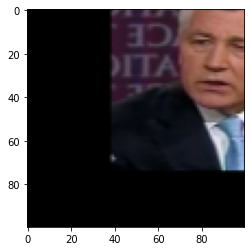

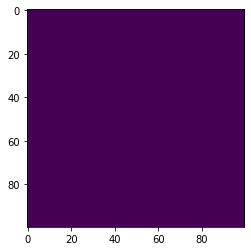

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


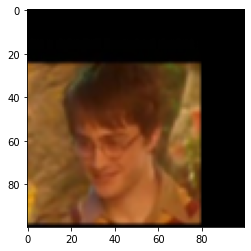

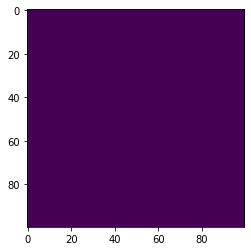

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


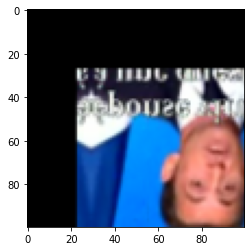

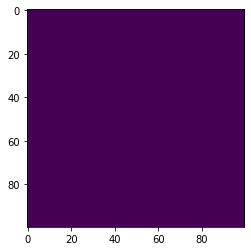

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


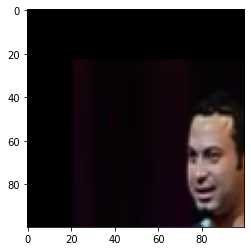

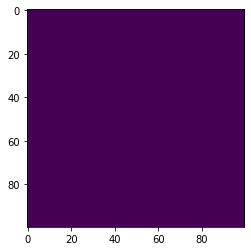

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


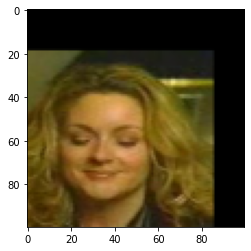

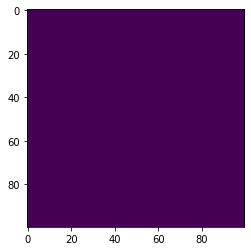

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


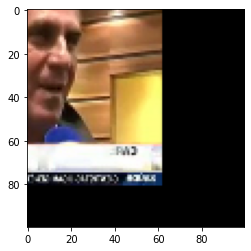

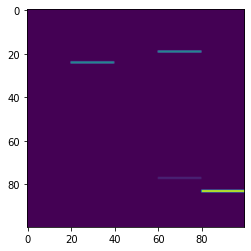

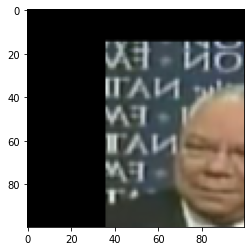

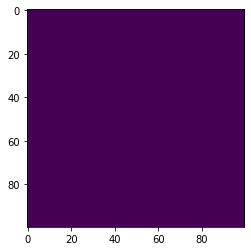

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


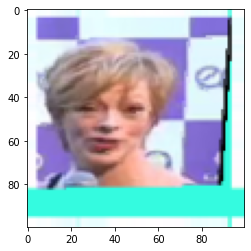

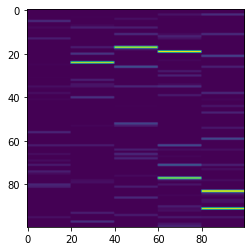

In [23]:
ixs = [0,1,2,3,4,5,6,7]
for ix in ixs:
    pred = preds[ix]
    img = target_images[ix]
    plt.imshow(img/255.)
    plt.show()
    plt.imshow(pred*255.)
    plt.show()

In [24]:
model_B = keras.models.Sequential([
    model,
    keras.layers.Dense(),
    )

SyntaxError: invalid syntax (<ipython-input-24-173244cc75c6>, line 4)